# Ejercicio 2. Entrenamiento de modelos de clasificación con Keras

## 0. Cabecera

**Nombre:** Ángel Manuel  
**Apellidos:** Calzado Llamas

In [2]:
# Librerías necesarias
from tensorflow import keras
import pathlib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import clone_model
from keras import regularizers
from keras_radam import RAdam

2022-04-12 16:29:47.606604: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# Funciones necesarias
def show_graphs(train_model):

    ent_acc = train_model.history['acc']
    val_acc = train_model.history['val_acc']
    ent_loss = train_model.history['loss']
    val_loss = train_model.history['val_loss']

    epochs = range(len(ent_acc))

    plt.plot(epochs, ent_acc, 'bo', label='Entrenamiento')
    plt.plot(epochs, val_acc, 'b', label='Validación')
    plt.title('Accuracy Entrenamiento y Validación')
    plt.legend()

    plt.figure()

    plt.plot(epochs, ent_loss, 'bo', label='Entrenamiento')
    plt.plot(epochs, val_loss, 'b', label='Validación')
    plt.title('Pérdida Entrenamiento y Validación')
    plt.legend()

    plt.show()

## 1. Dataset: descripción, carga y visualización

**Nombre del dataset:** Face Mask Detection Dataset  
**Fuente:** Kaggle  
**Descripción**: Presenta 10160 imágenes RGB dividas en 7893 para entrenamiento y 2267 para test. Imágenes obtenidas de Google search engine y del autor Prajna Bhandary's en github.

Las imágenes pueden pertenecer a una de estas dos clases:

**0 -> SI lleva mascarilla**  
**1 -> NO lleva mascarilla**

Decargamos el dataset en el ordenador con el siguiente código proporcionado en el enunciado del ejercicio. En él, decargamos el dataset con el uso de Keras. **Ejecutar la siguiente celda solo la primera vez.**

In [4]:
# Esta función de Keras descargará el dataset en $HOME/.keras
data_path = keras.utils.get_file(
    "mask_dataset.zip",
    "https://hdvirtual.us.es/discovirt/index.php/s/dijNRMPYfybYd3N/download",
    extract=True,
    archive_format='zip'
)

y almacenamos la ruta de este en `DATA_FOLDER`. También se nos indica la dimensión `128x128`, adecuada para la conversión de imágenes a tensores, que veremos en el siguiente apartado.

In [5]:
# La siguiente variable contiene la ruta al dataset.
DATA_FOLDER = pathlib.Path(data_path).parent / 'mask_ds' 

# Puedes usar el siguiente tamaño de imagen
IMAGE_SIZE = (128, 128)

Para ver la estructura que posee el dataset, consultaremos la ruta donde este se almacena con `!ls`

In [6]:
!ls $DATA_FOLDER
!ls $DATA_FOLDER/train

train  validation
with_mask  without_mask


Entonces, la estructura de los datos es la siguiente:
- train
    - with_mask
    - without_mask
- validation
    - with_mask
    - without_mask

Saber esto nos ayudará a preprocesar los datos de cara a la creación de los modelos. Por último, mostramos una imagen de una persona con mascarilla y una sin mascarilla. Para ello, utilizamos la clase `Image` de la librería `IPython.display`, pasándole como argumento la ruta de una imagen.

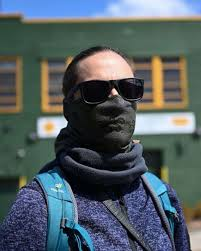

In [7]:
Image(filename= str(DATA_FOLDER) + '/train/with_mask/with_mask_2.jpg')

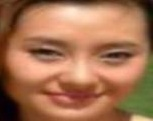

In [8]:
Image(filename= str(DATA_FOLDER) + '/train/without_mask/without_mask_4.jpg') 

## 2. Preparación de los datos para ser usados en keras

Como vimos en prácticas anteriores, para que nuestros modelos puedan trabajar con el dataset, debemos hacer las siguientes tareas:

* Leer los ficheros de imágenes.
* Decodificar JPEG en una matriz de RGB.
* Convertir la matriz en tensores de punto flotante.
* Re-escalar los valores de `[0,255]` a `[0, 1]`.

Para hacer todo esto de una sola vez, utilizaremos la función `ImageDataGenerator`, indicando únicamente el reescalado de los valores de los tensores resultantes. Para el conjunto de entrenamiento indicamos el parámetro `validation_split` para considerar un conjunto de validación en el entrenamiento.

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

Posteriormente, creamos los generadores para entrenamiento, validación y test con el uso de la función `flow_from_directory`, pasándole como parámetros:
- directorio de datos
- dimensión de las matrices RGB resultantes
- tamaño de batch que va a tener
- el tipo de etiquetas según el problema que estamos tratando. Al ser este un problema de clasificación binaria usamos `binary`
- subset, que nos sirve para indicar qué es entrenamiento y qué validación, y de esa manera crear también el generador para validación

In [10]:
# directorio de los datos para entrenamiento y test
train_dir = str(DATA_FOLDER) + '/train'
test_dir = str(DATA_FOLDER) + '/validation'

# generador para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
        train_dir,
        # Redimensión recomendada: 128x128
        target_size=IMAGE_SIZE,
        batch_size=20,
        class_mode='binary',
        subset="training")

# generador para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=20,
        class_mode='binary',
        subset="validation")

# generador para el conjunto de test
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=20,
        class_mode='binary')

Found 4230 images belonging to 2 classes.
Found 1056 images belonging to 2 classes.
Found 2267 images belonging to 2 classes.


En la salida se nos indica el número de imágenes de cada generador, pertenecientes a dos clases: con o sin mascarilla.

Como tenemos pensado utilizar la técnica de **Data Augmentation** en alguno de nuestros modelos, preparamos el generador con la posibilidad de generar más imágenes a partir de transformaciones sobre las imágenes originales. Vamos a ir comentando uno por uno los parámetros de la imagen que van a ser modificados:

**1. Rotación:**
Pensamos que sería buena idea rotar la imagen para que el modelo aprendiera a detectar personas con mascarilla que, quizá, están agachandose o asomandose por algún sitio; es decir, situaciones en las que la cara de la persona no está con una inclinación de 0º. El rango de rotación que se ha pensado es de [-45º, 45º], lo que sería una rotación no excesiva de la cabeza de una persona.

**2. Desplazamiento horizontal:**
Es una buena opción dado que podemos generar muchas más imágenes simplemente cambiando la posición de las personas. Además, es una buena idea que el modelo aprenda a identificar imágenes que puedan estar cortadas por algún extremo horizontal, para que no tenga la necesidad de "escanear" la cara entera a la hora de determinar si lleva mascarilla o no. Utilizamos un valor de 0.25 para garantizar que al menos, se vea medio rostro.

**3. Desplazamiento vertical:**
Buena idea por los mismos motivos que el desplazamiento horizontal. Usamos un valor de 0.25 (pequeño) para garantizar que se vea la parte descubierta del rostro tras ponerse la mascarilla.

**4. Doblez (shear):**
Como sabemos, nuestros ojos miran con perspectiva y esto hace que algunos objetos se vean doblados hacia el fondo o al frente. Una cámara no funciona distinto y sería bueno que pudiera identificar correctamente rostros a pesar de la perspectiva en la que esta se encuentre. Utilizamos un valor de 0.2 puesto que no queremos que sea algo tan excesivo que no sea real.

**5. Zoom:**
¿Qué cámara no tiene zoom? Poder identificar imágenes incluso haciendo zoom es una ventaja en todos los sentidos, aunque aportamos un valor pequeño de 0.2 para no llegar a enfocar unicamente a un punto de la cara irreconocible.

**6. Inversión horizontal (horizontal flip):**
¿Alguna vez ha notado la diferencia entre su rostro en el espejo y su rostro en cámara? Casi parecemos ver a dos personas distintas. La inversión horizontal de la imagen es muy útil porque, desde el punto de vista del cortex visual, estamos creando nuevos rostros (obviando las correlaciones). La inversión vertical no se considera porque sería raro encontrar casos en los que la persona estuviera boca abajo.

**7. Modo de relleno:**
Esta configuración va ligada a los ajustes número 2 y 3. `fill_mode` indica cómo se va a rellenar el espacio que sobre cuando desplacemos la imagen. Nosostros hemos preferido la opción `constant`, es decir, que se pinta en negro. Creemos que el modelo ignorará esa información de la imagen y funcionará mejor que otros modos en los que estira la imagen o la repite, lo cual podría modificar el rostro humano y perder patrones característicos.

**8. Brillo:**
No es lo mismo una imagen con el sol de cara que con sombra. Queremos que el modelo sea capaz de detectar los rostros independientemente de la iluminaciónde la imagen. Utilizamos un rango de 0.2 a 0.8, lo que podría ser el ajuste de brillo natural.

A continuación se muestra el código con la instancia de la clase `ImageDataGenerator` donde podrá ver, en orden, cada transformación escogida.

In [11]:
aug_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2,
      rotation_range=40,
      width_shift_range=0.25,
      height_shift_range=0.25,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='constant',
      brightness_range=(0.2,0.8))

Vamos a mostrar, sobre una imagen de una persona con mascarilla, algunas transformaciones aleatorias que se cometen con nuestro generador de imágenes creado. Para ello, utilizamos el código proporcionado por la práctica 5.2 en el que se toma una imagen desde la ruta donde se encuentra el dataset, se transforma a tensor redimensionado y se le pasa a nuestro generador por medio de la función `flow`, mostrando hasta 4 resultados distintos (la primera imagen es la original).

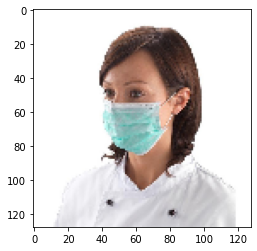

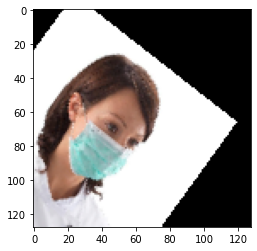

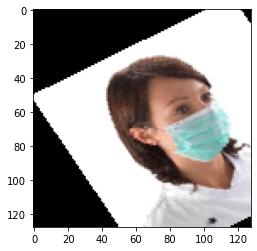

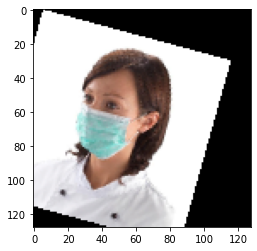

In [44]:
# ruta hacia las imágenes de entrenamiento con mascarilla
train_dir_with = train_dir + '/with_mask'

# array de rutas de las diferentes imágenes contenidas en la ruta anterior
fnames = [os.path.join(train_dir_with, fname) for fname in os.listdir(train_dir_with)]

# Escogemos una imagen para transformar
img_path = fnames[3]

# Lee la imagen y la redimensiona
img = image.load_img(img_path, target_size=(128, 128))

# La convierte a un Numpy array con dimensiones (128, 128, 3)
x = image.img_to_array(img)

# Se redimensiona a (1, 128, 128, 3)
x = x.reshape((1,) + x.shape)

# Mostramos la imagen original para comparar
plt.figure(0)
plt.imshow(image.array_to_img(x[0]))

# Iteramos sobre batches creados mediante la función flow de imágenes generadas a partir de la original
# mostramos solo 4.
i = 1
for batch in aug_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Por último, creamos el generador a partir de las transformaciones configuradas. Recuerde que solo lo hacemos para el conjunto de entrenamiento. Los datos de test deben ser totalmente ajenos al proceso de entrenamiento por lo que solo hemos reescalados sus valores.

In [45]:
train_generator_aug = aug_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=16,
        class_mode='binary')

Found 5286 images belonging to 2 classes.


## 3. Modelos y configuraciones

Una vez tenemos los datos listos para ser procesados por nuestros modelos, es hora de crearlos.

La estructura de este apartado y los siguientes va ser la siguiente: 

Crearemos 4 modelos sustancialmente diferentes con los aspectos que se nos piden que juguemos (arquitectura, optimizadores, etc); pero dentro de cada subapartado procuraremos mejorar el modelo que estamos estudiando con alguna técnica (early-stopping, dropout, etc).

De esta forma, usted podrá discernir entre 4 modelos muy diferentes con los que se pretende abarcar las distintas posibilidades que Keras nos brinda y cada uno de ellos ira acompañado 1 modelo más que intentará corregirlo. En pocas palabras:

- Modelo 1:
    - modelo 1
    - posible mejora para el modelo 1
- Modelo 2:
    - modelo 2
    - posible mejora para el modelo 2
- Modelo 3:
    - modelo 3
    - posible mejora para el modelo 3
- Modelo 4:
    - modelo 4
    - posible mejora para el modelo 4

### 3.1 Modelo 1

Se trata de una red convolucional simplificada con respecto a las que hemos visto en prácticas anteriores.

En la siguiente lista podemos ver de qué se compone:

- Estructura:
    - 1 capa convolucional de 32 filtros 3x3 y función de activación ReLU
    - 1 capa maxpooling 2x2
    - 1 capa convolucional de 64 filtros 3x3 y función de activación ReLU
    - 1 capa maxpooling 2x2
    - 1 capa densa de 512 nodos con función de activación ReLU
    - 1 capa de salida con función de activación sigmoide
- Compile:
    - binary_crossentropy como función de pérdida
    - rmsprop como optimizador
    - precisión como métrica de evaluación
- Epochs: 10

¿Por qué hemos configurado así el modelo?
- activación ReLU: porque es la recomendada de inicio
- pooling maxpooling: para reducir el número de parámetros y evitar errores
- estructura simplificada: porque queremos partir de un modelo mínimo para ver cuál es el rendimiento de partida y luego ir aumentando capacidades con otros modelos.
- optimizador RMSprop: al ser recomendable según estudios y ser el usado por defecto en las prácticas
- epochs 10: para optimizar la carga computacional


Creamos el modelo con el uso de `Sequential` y añadimos las capas indicadas

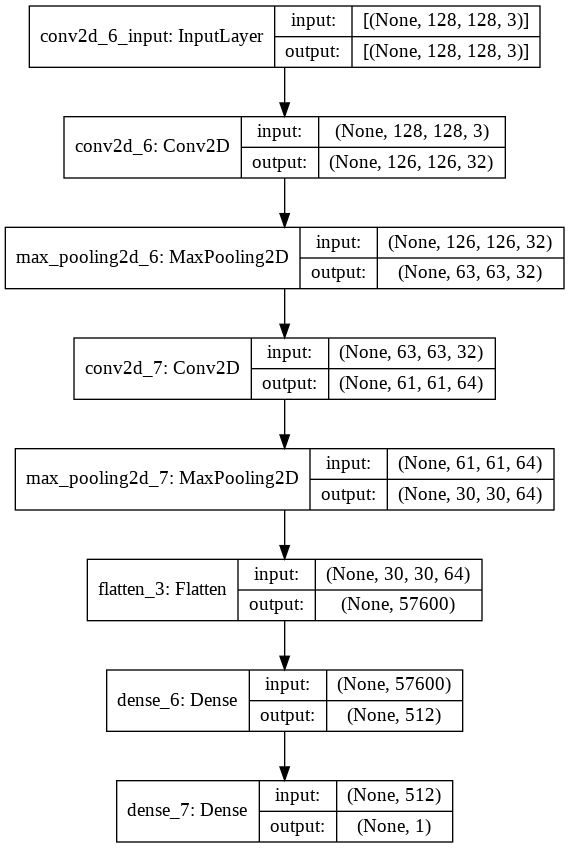

In [27]:
# Creación del modelo
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

# Compilación
model1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Diagrama del modelo
plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)

Podemos ver un resumen más claro del modelo con `summary`

In [28]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               29491712  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

#### Posible mejora del modelo 1

En el apartado 4.1 proponemos el uso del método early-stopping para evitar el sobreajuste del modelo. Creamos un modelo clon del anterior (para no entrenar dos veces un mismo modelo el cual conservaría los pesos tras el primer entrenamiento) con la función `clone_model` y lo compilamos de la misma forma que su original.

In [29]:
model1_improvement = clone_model(model1)

model1_improvement.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 3.2 Modelo 2

Se trata de una red convolucional más compleja. En la siguiente lista podemos ver de qué se compone:

- Estructura:
    - 1 capa convolucional de 32 filtros 3x3 y función de activación Leaky ReLU
    - 1 capa averagepooling 2x2
    - 1 capa convolucional de 64 filtros 3x3 y función de activación Leaky ReLU
    - 1 capa averagepooling 2x2
    - 1 capa convolucional de 128 filtros 3x3 y función de activación Leaky ReLU
    - 1 capa averagepooling 2x2
    - 1 capa convolucional de 128 filtros 3x3 y función de activación Leaky ReLU
    - 1 capa averagepooling 2x2
    - 1 capa densa de 512 nodos con función de activación Leaky ReLU
    - 1 capa densa de 256 nodos con función de activación Leaky ReLU
    - 1 capa de salida con función de activación sigmoide
- Compile:
    - binary_crossentropy como función de pérdida
    - SGD como optimizador
    - precisión como métrica de evaluación
- Epochs: 20

¿Por qué hemos configurado así el modelo?
- activación Leaky ReLU: porque no se satura tanto en la región positiva y evita dying ReLUs que se hayan podido generar en el modelo anterior
- pooling averagepooling: para comparar el resultado con maxpooling
- estructura con más capas convolucionales y densas: comprobar si podemos obtener mejores resultados con el cálculo de más parámetros.
- optimizador SGD: porque es un optimizador también recomendable y podemos jugar con Nesterov y Momentum para mejorarlo
- más epochs: dar más oportunidad de encontrar un mínimo global en la pérdida.

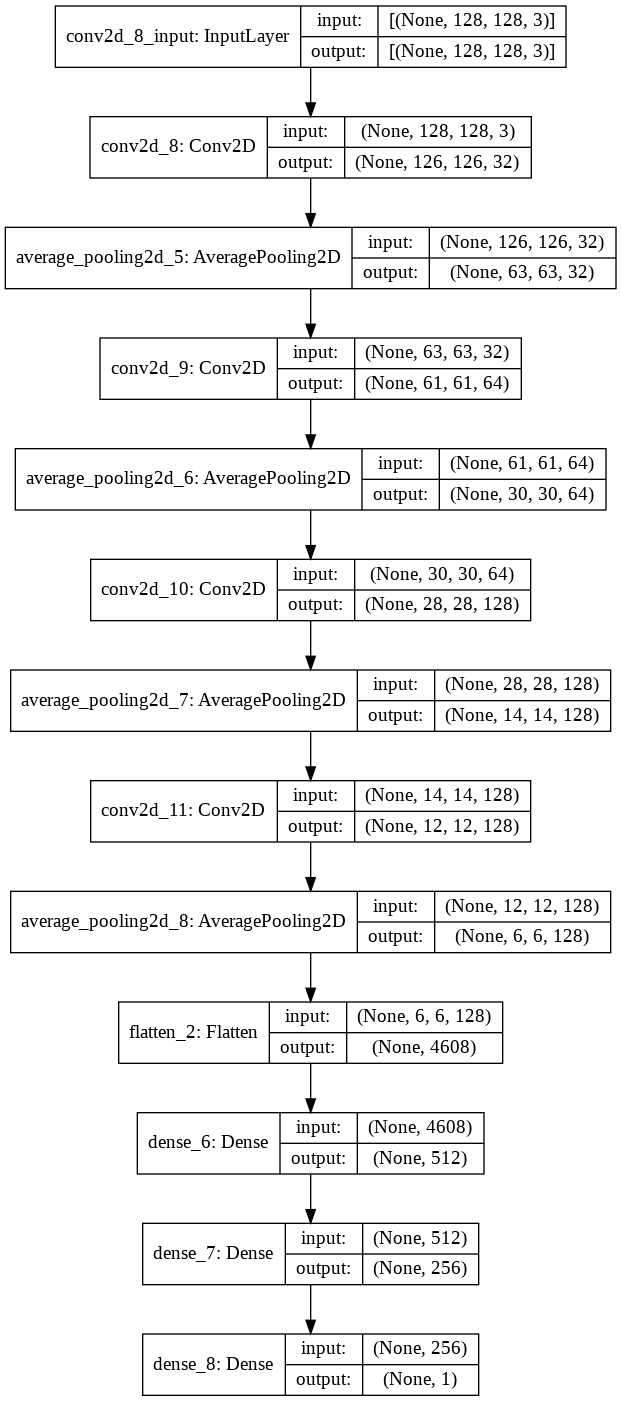

In [49]:
# Creación del modelo
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation=keras.layers.LeakyReLU(),
                        input_shape=(128, 128, 3)))
model2.add(layers.AveragePooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation=keras.layers.LeakyReLU()))
model2.add(layers.AveragePooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation=keras.layers.LeakyReLU()))
model2.add(layers.AveragePooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation=keras.layers.LeakyReLU()))
model2.add(layers.AveragePooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation=keras.layers.LeakyReLU()))
model2.add(layers.Dense(256, activation=keras.layers.LeakyReLU()))
model2.add(layers.Dense(1, activation='sigmoid'))

# Compilación
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(),
              metrics=['acc'])

# Diagrama del modelo
plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True)

Aquí el resumen

In [50]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
average_pooling2d_5 (Average (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
average_pooling2d_6 (Average (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
average_pooling2d_7 (Average (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)      

#### Posible mejora para el modelo 2

Como estamos haciendo uso del optimizador SGD, vamos a agregarle Momentum (ganancia de más velocidad en más pendiente) y Nesterov (reducción de la velocidad cuando la pendiente cambia).

Para ello, creamos de nuevo el modelo e incluimos en la función `SGD` el parámetro `momentum` con valor 0.9 (valor más común) y el parámetro `nesterov` a True para que se aplique.

In [51]:
model2_improvement = clone_model(model2)

model2_improvement.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(momentum=0.9, nesterov=True),
              metrics=['acc'])

### 3.3 Modelo 3

En la siguiente lista podemos ver de qué se compone:

- Estructura:
    - 1 capa convolucional de 32 filtros 3x3 y función de activación ELU
    - 1 capa averagepooling 2x2
    - 1 capa convolucional de 64 filtros 3x3 y función de activación ELU
    - 1 capa averagepooling 2x2
    - 1 capa convolucional de 128 filtros 3x3 y función de activación ELU
    - 1 capa averagepooling 2x2
    - 1 capa convolucional de 128 filtros 3x3 y función de activación ELU
    - 1 capa averagepooling 2x2
    - 1 capa convolucional de 256 filtros 3x3 y función de activación ELU
    - 1 capa convolucional de 256 filtros 3x3 y función de activación ELU
    - 1 capa averagepooling 2x2
    - 1 capa densa de 200 nodos con función de activación ReLU y regularización L1
    - 1 capa densa de 200 nodos con función de activación ReLU y regularización L1
    - 1 capa densa de 200 nodos con función de activación ReLU y regularización L1
    - 1 capa de salida con función de activación sigmoide
- Compile:
    - binary_crossentropy como función de pérdida
    - Adam como optimizador
    - precisión como métrica de evaluación
- Epochs: 15

¿Por qué hemos configurado así el modelo?
- activación ELU: porque posee todas las ventajas de ReLU y no da lugar a dying ReLU's. En las capas densas usamos ReLU para probar como funciona el modelo con la unión de diferentes funciones de activación
- pooling averagepooling: para comparar el resultado con maxpooling y reducir parámetros
- estructura con más capas convolucionales y densas: como pretendemos utilizar como mejora para este modelo el método Dropout, creamos una red más compleja porque parece que funciona mejor en ese tipo de estructuras.
- optimizador Adam: porque es el optimizador recomendado por defecto que une Adadelta y Adagrad.

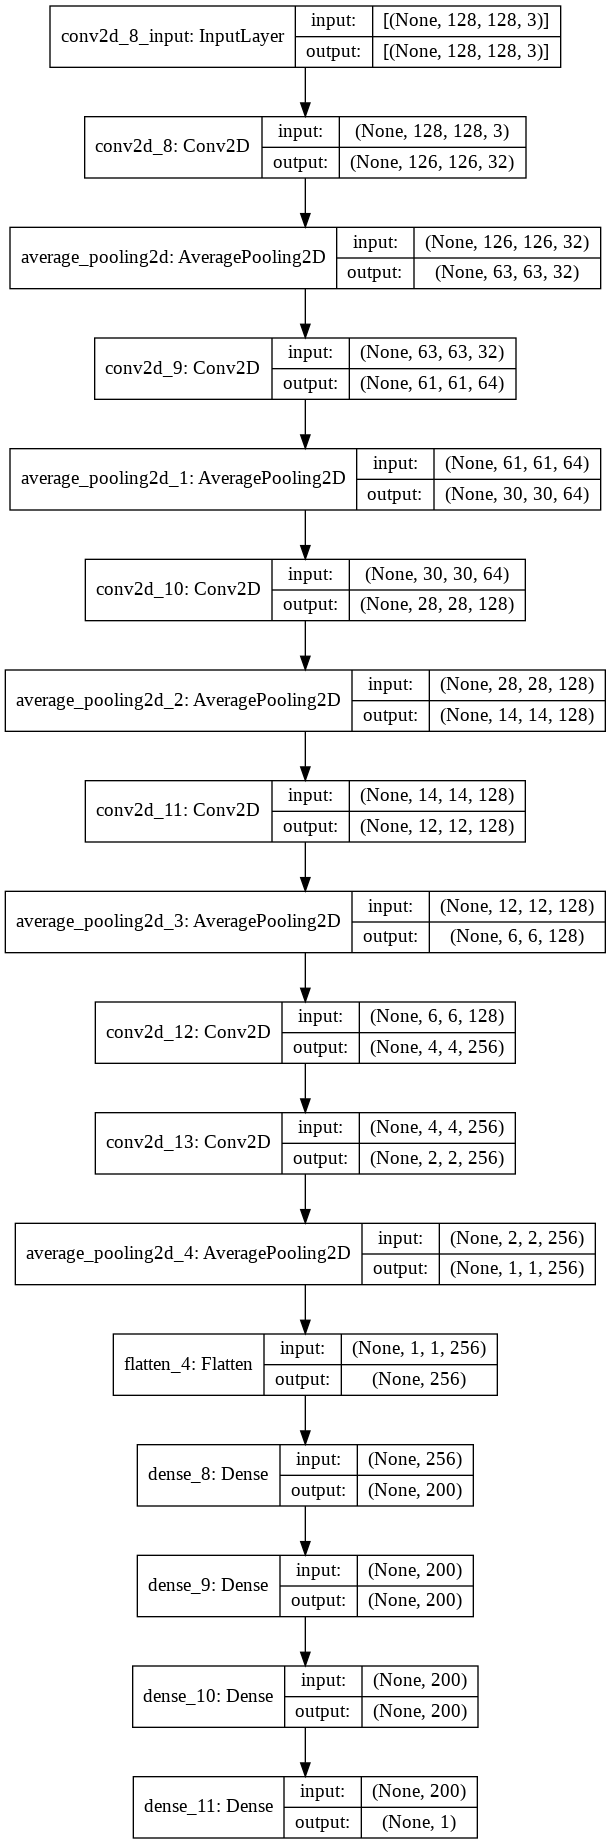

In [34]:
# Creación del modelo
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='elu',
                        input_shape=(128, 128, 3)))
model3.add(layers.AveragePooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='elu'))
model3.add(layers.AveragePooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='elu'))
model3.add(layers.AveragePooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='elu'))
model3.add(layers.AveragePooling2D((2, 2)))
model3.add(layers.Conv2D(256, (3, 3), activation='elu'))
model3.add(layers.Conv2D(256, (3, 3), activation='elu'))
model3.add(layers.AveragePooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(200, activation='relu'))
model3.add(layers.Dense(200, activation='relu'))
model3.add(layers.Dense(200, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

# Compilación
model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

# Diagrama del modelo
plot_model(model3, to_file='model3.png', show_shapes=True, show_layer_names=True)

In [35]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 128)      

#### Posible mejora para el modelo 3

Vamos a utilizar la técnica de Dropout como método de regularización del modelo, en caso de que pudiera sobreajustarse el primero.

Como sabemos Dropout consiste en poner a cero algunas neuronas durante el proceso de propagación hacia adelante, lo que hace que se desactiven y no actualicen. Para añadir Dropout al modelo es tan simple como añadir capas propias con la función `Droput` de la librería `layers` de Keras, indicando el factor de desactivación (probabilidad de poner una neurona aleatoria a 0). Normalmente se suele jugar con valores de probabilidad de entre 0.2 y 0.5; y como solo vamos a hacer una prueba, utilizamos el valor intermedio 0.3.

Como se comentaba en la práctica de regularización, es bueno aplicar regularización lasso a las capas de nuestra estructura con el fin de penalizar pesos muy altos. Añadimos dicha regularización a las capas densas de nuestro modelo indicando un parámetro adicional `kernel_regularizer` igual a `regularizer.l1` con factor de aprendizaje 0.01

In [36]:
# Creación del modelo
model3_improvement = models.Sequential()
model3_improvement.add(layers.Conv2D(32, (3, 3), activation='elu',
                        input_shape=(128, 128, 3)))
model3_improvement.add(layers.AveragePooling2D((2, 2)))
model3_improvement.add(layers.Conv2D(64, (3, 3), activation='elu'))
model3_improvement.add(layers.AveragePooling2D((2, 2)))
model3_improvement.add(layers.Conv2D(128, (3, 3), activation='elu'))
model3_improvement.add(layers.AveragePooling2D((2, 2)))
model3_improvement.add(layers.Conv2D(128, (3, 3), activation='elu'))
model3_improvement.add(layers.AveragePooling2D((2, 2)))
model3_improvement.add(layers.Conv2D(256, (3, 3), activation='elu'))
model3_improvement.add(layers.Conv2D(256, (3, 3), activation='elu'))
model3_improvement.add(layers.AveragePooling2D((2, 2)))
model3_improvement.add(layers.Flatten())
model3_improvement.add(layers.Dense(200, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
model3_improvement.add(layers.Dropout(0.3))
model3_improvement.add(layers.Dense(200, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
model3_improvement.add(layers.Dropout(0.3))
model3_improvement.add(layers.Dense(200, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
model3_improvement.add(layers.Dropout(0.3))
model3_improvement.add(layers.Dense(1, activation='sigmoid'))

# Compilación
model3_improvement.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

### 3.4 Modelo 4

En la siguiente lista podemos ver de qué se compone:

- Estructura:
    - 1 capa convolucional de 32 filtros 3x3 y función de activación ELU
    - 1 capa maxpooling 2x2
    - 1 capa convolucional de 64 filtros 3x3 y función de activación tanh
    - 1 capa maxpooling 2x2
    - 1 capa convolucional de 128 filtros 3x3 y función de activación ELU
    - 1 capa maxpooling 2x2
    - 1 capa convolucional de 128 filtros 3x3 y función de activación tanh
    - 1 capa maxpooling 2x2
    - 1 capa convolucional de 256 filtros 3x3 y función de activación ELU
    - 1 capa maxpooling 2x2
    - 1 capa densa de 100 nodos con función de activación tanh
    - 1 capa densa de 100 nodos con función de activación ELU
    - 1 capa densa de 100 nodos con función de activación tanh
    - 1 capa densa de 100 nodos con función de activación ELU
    - 1 capa de salida con función de activación sigmoide
- Compile:
    - binary_crossentropy como función de pérdida
    - Radam como optimizador
    - precisión como métrica de evaluación
- Epochs: 40

¿Por qué hemos configurado así el modelo?
- activación ELU y tanh:  Al ser gráficas parecidas, queremos ver como funcionan en conjunto
- pooling maxpooling: para reducir los flatmaps a aquellas celdas más significativas
- estructura con más capas densas: para comparar si es mejor pocas capas con muchos nodos o muchas capas con pocos nodos.
- optimizador Radam: para comparar con Adam, ya que es una variación de este, y evitar preocuparnos por un valor de learning rate, al calcularse este hiperparámetro de forma dinámica y automática.

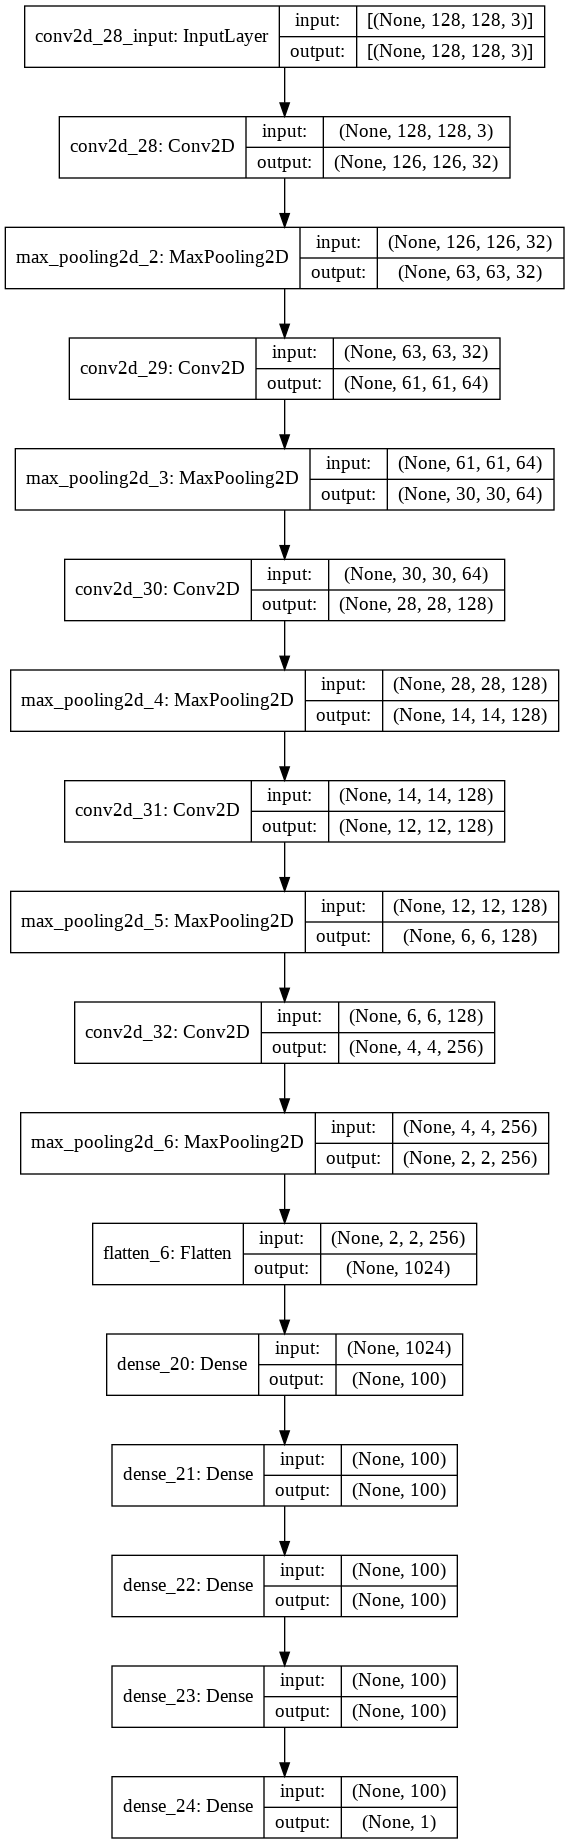

In [55]:
# Creación del modelo
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='elu',
                        input_shape=(128, 128, 3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='elu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='tanh'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(256, (3, 3), activation='elu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(100, activation='tanh'))
model4.add(layers.Dense(100, activation='elu'))
model4.add(layers.Dense(100, activation='tanh'))
model4.add(layers.Dense(100, activation='elu'))
model4.add(layers.Dense(1, activation='sigmoid'))

# Compilación
model4.compile(loss='binary_crossentropy',
              optimizer=RAdam(),
              metrics=['acc'])

# Diagrama del modelo
plot_model(model4, to_file='model4.png', show_shapes=True, show_layer_names=True)

Resumen

In [56]:
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 12, 12, 128)      

#### Posible mejora para el modelo 4

Queremos estudiar en este modelo como funcionaría la técnica de Data Augmentation, consistente en ampliar el número de imágenes (ejemplos) mediante trasnformaciones (rotación, traslación, ...) a las imágenes originales. En el apartado de preprocesado vimos como preparar los nuevos datos y en el apartado 4 veremos como incluirlos.

De momento, clonamos el modelo para ser utilizado posteriormente en la etapa de entrenamiento y lo compilamos.

In [57]:
model4_improvement = clone_model(model4)

# Compilación
model4_improvement.compile(loss='binary_crossentropy',
              optimizer=RAdam(),
              metrics=['acc'])

## 4. Entrenamiento y evaluación

Una vez descritos y creados todos los modelos, pasamos a entrenarlos y evaluarlos. En este apartado explicamos el procedimiento y en el apartado 5 hablaremos de los resultados obtenidos.

### 4.1 Modelo 1

Entrenamos el modelo con el uso de su función `fit`, pasándole por parámetros los generadores para el conjunto de entrenamiento y validación.

Indicamos, además, el número de batches que constituye un epoch en cada conjunto, ya que el generador crea indefinidamente batches recorriendo el conjunto de imágenes y, por tanto, se debe indicar de cuántos batches o ejemplos consta un epoch. En este caso:
- Como tenemos >4000 ejemplos en el conjunto de entrenamiento y nuestro generador crea batches de 20 imágenes
    - steps_per_epoch = 4000/20 = 200
- Como tenemos >1000 ejemplos en el conjunto de validación y nuestro generador crea batches de 20 imágenes
    - validation_steps = 1000/20 = 50

In [58]:
train_model1 = model1.fit(
      train_generator,
      steps_per_epoch=200,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/10
 18/200 [=>............................] - ETA: 10s - loss: 1.1197 - acc: 0.5615

/home/dlstudent1/.conda/envs/tf-gpu/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200/200 [==============================] - 12s 56ms/step - loss: 0.6775 - acc: 0.6832 - val_loss: 0.3145 - val_acc: 0.8660
Epoch 2/10
200/200 [==============================] - 11s 56ms/step - loss: 0.2861 - acc: 0.8866 - val_loss: 0.2523 - val_acc: 0.9110
Epoch 3/10
200/200 [==============================] - 11s 56ms/step - loss: 0.2138 - acc: 0.9138 - val_loss: 0.2248 - val_acc: 0.9120
Epoch 4/10
200/200 [==============================] - 11s 56ms/step - loss: 0.1882 - acc: 0.9284 - val_loss: 0.2167 - val_acc: 0.9120
Epoch 5/10
200/200 [==============================] - 11s 56ms/step - loss: 0.1339 - acc: 0.9470 - val_loss: 0.2523 - val_acc: 0.9130
Epoch 6/10
200/200 [==============================] - 11s 56ms/step - loss: 0.1053 - acc: 0.9630 - val_loss: 0.2274 - val_acc: 0.9070
Epoch 7/10
200/200 [==============================] - 11s 55ms/step - loss: 0.0806 - acc: 0.9732 - val_loss: 0.2148 - val_acc: 0.9220
Epoch 8/10
200/200 [==============================] - 11s 54ms/step - los

Gracias al código proporcionado en las prácticas, mostramos como ha sido el proceso de entrenamiento y validación mostrando dos gráficas:
1. Compara, para entrenamiento y validación, el valor de la precisión en cada epoch
2. Compara, para entrenamiento y validación, el valor de la función de pérdida en cada epoch

El código se encuentra en la cabecera del documento, nosotros lo hemos referenciado en una función llamada `show_graphs`, que recibe el modelo entrenado, para no cargar de código las evaluaciones 

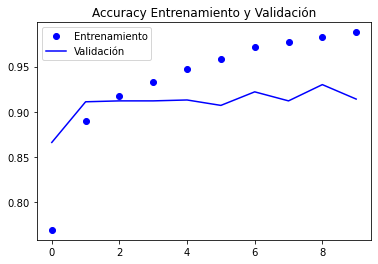

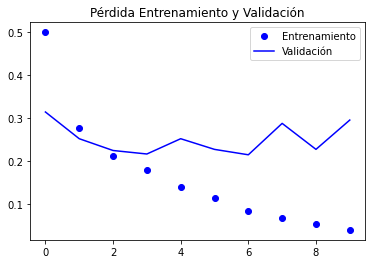

In [59]:
show_graphs(train_model1)

Por último evaluamos el modelo sobre el conjunto de test mediante el uso de la función `evaluate`, pasándole como parámetro únicamente el generador de dicho conjunto.

In [60]:
model1.evaluate(test_generator)

114/114 [==============================] - 4s 36ms/step - loss: 0.2660 - acc: 0.9166


[0.26596832275390625, 0.9166299104690552]

#### Posible mejora del modelo 1

Como podemos ver en las gráficas de precisión y pérdida, el modelo empieza a sobreajustarse a partir del epoch 3, justo cuando  la gráfica de validación se estabiliza.

Para evitar el sobreajuste, haremos uso de la técnica del Early Stopping. Dicha técnica produce una parada en el entrenamiento cuando detecta que los resultados sobre el conjunto de validación comienzan a estancarse, significando eso un sobreajuste del modelo.

Con la clase `EarlyStopping` de la librería `callbacks` de `keras`, podemos implementar dicha técnica en nuestros modelos. Recibe por parámetros un `monitor`, es decir, el valor que va a revisar para detectar cuando parar el entrenamiento; y un valor `patience` que indica cuántos epochs debe esperar el modelo sin encontrar valores adecuados hasta pararse. 

Por ejemplo: Si estamos revisando el valor de pérdida sobre el conjunto de validación, si en un epoch el valor de pérdida es mayor que el anterior, el modelo tiene `patience` epochs hasta poder encontrar un mejor valor, sino, el entrenamiento termina.

Explicado esto, lo implementamos en la siguiente celda

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [31]:
train_model1_improvement = model1_improvement.fit(
      train_generator,
      steps_per_epoch=200,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[early_stopping])

Epoch 1/10
131/200 [==================>...........] - ETA: 3s - loss: 0.7935 - acc: 0.6340

/home/dlstudent1/.conda/envs/tf-gpu/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200/200 [==============================] - 11s 54ms/step - loss: 0.6945 - acc: 0.6769 - val_loss: 0.2837 - val_acc: 0.9010
Epoch 2/10
200/200 [==============================] - 11s 56ms/step - loss: 0.2837 - acc: 0.8891 - val_loss: 0.3796 - val_acc: 0.8510
Epoch 3/10
200/200 [==============================] - 11s 56ms/step - loss: 0.2256 - acc: 0.9115 - val_loss: 0.2423 - val_acc: 0.9140
Epoch 4/10
200/200 [==============================] - 11s 55ms/step - loss: 0.1926 - acc: 0.9228 - val_loss: 0.2351 - val_acc: 0.9110
Epoch 5/10
200/200 [==============================] - 11s 55ms/step - loss: 0.1637 - acc: 0.9393 - val_loss: 0.2253 - val_acc: 0.9130
Epoch 6/10
200/200 [==============================] - 11s 56ms/step - loss: 0.1294 - acc: 0.9546 - val_loss: 0.2378 - val_acc: 0.9170
Epoch 7/10
200/200 [==============================] - 11s 56ms/step - loss: 0.1016 - acc: 0.9692 - val_loss: 0.2208 - val_acc: 0.9170
Epoch 8/10
200/200 [==============================] - 11s 56ms/step - los

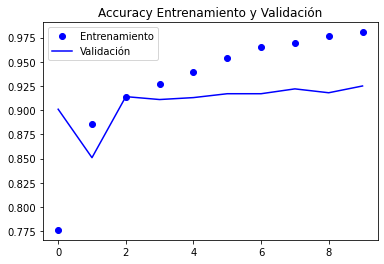

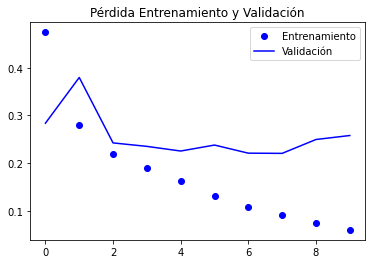

In [32]:
show_graphs(train_model1_improvement)

In [33]:
model1_improvement.evaluate(test_generator)

114/114 [==============================] - 4s 36ms/step - loss: 0.2469 - acc: 0.9171


[0.24692882597446442, 0.9170710444450378]

### 4.2 Modelo 2

Entrenamos el modelo con 20 epochs

In [65]:
train_model2 = model2.fit(
      train_generator,
      steps_per_epoch=200,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/20
200/200 [==============================] - 10s 51ms/step - loss: 0.6884 - acc: 0.5561 - val_loss: 0.6729 - val_acc: 0.6300
Epoch 2/20
200/200 [==============================] - 10s 49ms/step - loss: 0.6298 - acc: 0.6861 - val_loss: 0.8528 - val_acc: 0.4880
Epoch 3/20
200/200 [==============================] - 10s 49ms/step - loss: 0.4502 - acc: 0.7940 - val_loss: 0.2637 - val_acc: 0.9130
Epoch 4/20
200/200 [==============================] - 10s 49ms/step - loss: 0.3378 - acc: 0.8564 - val_loss: 0.2537 - val_acc: 0.8950
Epoch 5/20
200/200 [==============================] - 10s 50ms/step - loss: 0.3173 - acc: 0.8719 - val_loss: 0.2371 - val_acc: 0.9080
Epoch 6/20
200/200 [==============================] - 10s 49ms/step - loss: 0.2970 - acc: 0.8762 - val_loss: 0.2201 - val_acc: 0.9240
Epoch 7/20
200/200 [==============================] - 10s 49ms/step - loss: 0.2930 - acc: 0.8861 - val_loss: 0.2264 - val_acc: 0.9160
Epoch 8/20
200/200 [==============================] - 10s 50ms

Y mostramos las gráficas

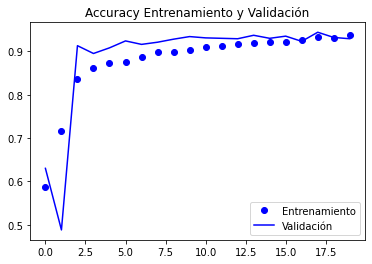

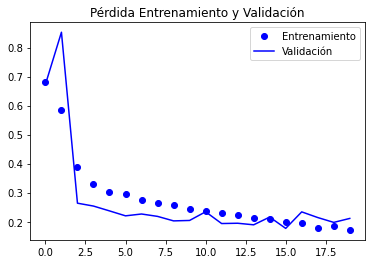

In [66]:
show_graphs(train_model2)

En el apartado 5 comentaremos los resultados. Por último, mostramos los resultados sobre el conjunto de test

In [67]:
model2.evaluate(test_generator)

114/114 [==============================] - 4s 36ms/step - loss: 0.1989 - acc: 0.9237


[0.19889071583747864, 0.9236876964569092]

#### Posible mejora para el modelo 2

Entrenamos el modelo con Momentum y Nesterov

In [68]:
train_model2_improvement = model2_improvement.fit(
      train_generator,
      steps_per_epoch=200,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/20
200/200 [==============================] - 10s 50ms/step - loss: 0.5687 - acc: 0.6828 - val_loss: 0.2335 - val_acc: 0.9130
Epoch 2/20
200/200 [==============================] - 10s 50ms/step - loss: 0.2825 - acc: 0.8825 - val_loss: 0.2206 - val_acc: 0.9240
Epoch 3/20
200/200 [==============================] - 10s 50ms/step - loss: 0.2479 - acc: 0.8999 - val_loss: 0.2073 - val_acc: 0.9360
Epoch 4/20
200/200 [==============================] - 10s 50ms/step - loss: 0.1985 - acc: 0.9253 - val_loss: 0.1736 - val_acc: 0.9490
Epoch 5/20
200/200 [==============================] - 10s 50ms/step - loss: 0.1728 - acc: 0.9365 - val_loss: 0.1854 - val_acc: 0.9360
Epoch 6/20
200/200 [==============================] - 10s 50ms/step - loss: 0.1438 - acc: 0.9467 - val_loss: 0.1894 - val_acc: 0.9420
Epoch 7/20
200/200 [==============================] - 10s 49ms/step - loss: 0.1410 - acc: 0.9525 - val_loss: 0.1683 - val_acc: 0.9500
Epoch 8/20
200/200 [==============================] - 10s 50ms

Mostramos las gráficas

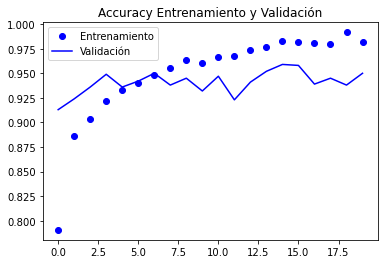

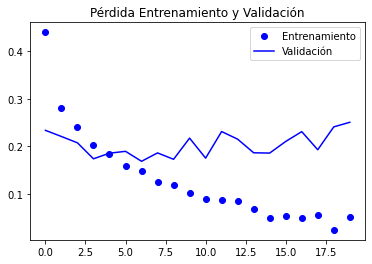

In [69]:
show_graphs(train_model2_improvement)

y el rendimiento sobre el conjunto de test

In [70]:
model2_improvement.evaluate(test_generator)

114/114 [==============================] - 4s 36ms/step - loss: 0.2622 - acc: 0.9413


[0.26219263672828674, 0.9413321614265442]

### 4.3 Modelo 3

Entrenamos el modelo como los anteriores

In [37]:
train_model3 = model3.fit(
      train_generator,
      steps_per_epoch=200,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/15
 47/200 [======>.......................] - ETA: 6s - loss: 0.7645 - acc: 0.5791

/home/dlstudent1/.conda/envs/tf-gpu/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200/200 [==============================] - 11s 52ms/step - loss: 0.5593 - acc: 0.7234 - val_loss: 0.2287 - val_acc: 0.9140
Epoch 2/15
200/200 [==============================] - 10s 50ms/step - loss: 0.2946 - acc: 0.8833 - val_loss: 0.2119 - val_acc: 0.9320
Epoch 3/15
200/200 [==============================] - 10s 51ms/step - loss: 0.2473 - acc: 0.9115 - val_loss: 0.1911 - val_acc: 0.9290
Epoch 4/15
200/200 [==============================] - 10s 49ms/step - loss: 0.2444 - acc: 0.9003 - val_loss: 0.2038 - val_acc: 0.9340
Epoch 5/15
200/200 [==============================] - 10s 51ms/step - loss: 0.2571 - acc: 0.9063 - val_loss: 0.1754 - val_acc: 0.9470
Epoch 6/15
200/200 [==============================] - 10s 50ms/step - loss: 0.1976 - acc: 0.9241 - val_loss: 0.1752 - val_acc: 0.9520
Epoch 7/15
200/200 [==============================] - 10s 51ms/step - loss: 0.1893 - acc: 0.9291 - val_loss: 0.1572 - val_acc: 0.9510
Epoch 8/15
200/200 [==============================] - 10s 50ms/step - los

Mostramos las gráficas

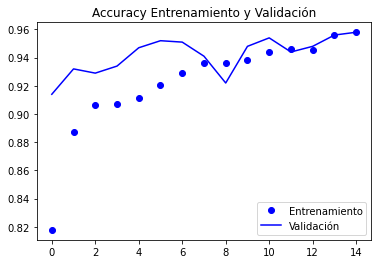

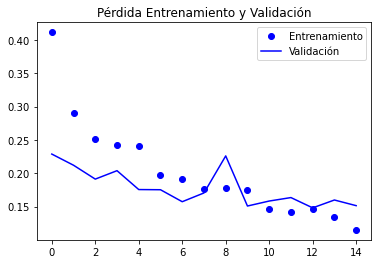

In [38]:
show_graphs(train_model3)

Evaluamos sobre test

In [39]:
model3.evaluate(test_generator)

114/114 [==============================] - 4s 37ms/step - loss: 0.1577 - acc: 0.9471


[0.1577124297618866, 0.947066605091095]

#### Posible mejora para el modelo 3

Evaluamos el modelo usando Dropout

In [74]:
train_model3_improvement = model3_improvement.fit(
      train_generator,
      steps_per_epoch=200,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/15
200/200 [==============================] - 11s 53ms/step - loss: 39.6617 - acc: 0.6792 - val_loss: 0.6105 - val_acc: 0.9300
Epoch 2/15
200/200 [==============================] - 10s 52ms/step - loss: 0.6325 - acc: 0.9019 - val_loss: 0.4629 - val_acc: 0.9190
Epoch 3/15
200/200 [==============================] - 10s 50ms/step - loss: 0.5347 - acc: 0.8959 - val_loss: 0.4307 - val_acc: 0.9280
Epoch 4/15
200/200 [==============================] - 10s 51ms/step - loss: 0.5294 - acc: 0.8844 - val_loss: 0.4176 - val_acc: 0.9450
Epoch 5/15
200/200 [==============================] - 10s 51ms/step - loss: 0.5117 - acc: 0.9023 - val_loss: 0.4292 - val_acc: 0.9400
Epoch 6/15
200/200 [==============================] - 10s 51ms/step - loss: 0.4680 - acc: 0.9113 - val_loss: 0.4237 - val_acc: 0.9450
Epoch 7/15
200/200 [==============================] - 10s 51ms/step - loss: 0.4366 - acc: 0.9252 - val_loss: 0.4782 - val_acc: 0.9490
Epoch 8/15
200/200 [==============================] - 10s 52m

Mostramos las gráficas

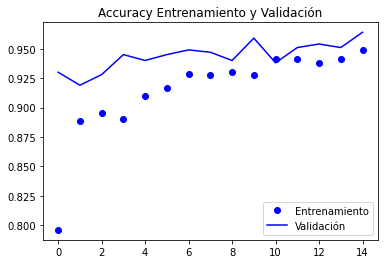

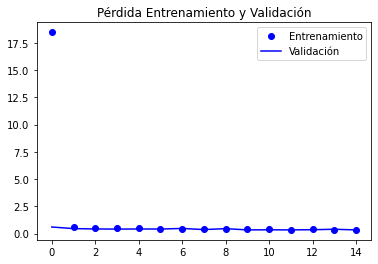

In [75]:
show_graphs(train_model3_improvement)

Evaluamos sobre test

In [76]:
model3_improvement.evaluate(test_generator)

114/114 [==============================] - 4s 36ms/step - loss: 0.3612 - acc: 0.9484


[0.3611646592617035, 0.9483899474143982]

### 4.4 Modelo 4

Entrenamos el modelo

In [77]:
train_model4 = model4.fit(
      train_generator,
      steps_per_epoch=200,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/40
200/200 [==============================] - 13s 56ms/step - loss: 0.5126 - acc: 0.6973 - val_loss: 0.1814 - val_acc: 0.9410
Epoch 2/40
200/200 [==============================] - 11s 55ms/step - loss: 0.2334 - acc: 0.9078 - val_loss: 0.1760 - val_acc: 0.9430
Epoch 3/40
200/200 [==============================] - 11s 55ms/step - loss: 0.1973 - acc: 0.9231 - val_loss: 0.1500 - val_acc: 0.9520
Epoch 4/40
200/200 [==============================] - 11s 56ms/step - loss: 0.1432 - acc: 0.9445 - val_loss: 0.1182 - val_acc: 0.9580
Epoch 5/40
200/200 [==============================] - 11s 55ms/step - loss: 0.1294 - acc: 0.9525 - val_loss: 0.1589 - val_acc: 0.9520
Epoch 6/40
200/200 [==============================] - 11s 55ms/step - loss: 0.1030 - acc: 0.9653 - val_loss: 0.1454 - val_acc: 0.9490
Epoch 7/40
200/200 [==============================] - 11s 55ms/step - loss: 0.0925 - acc: 0.9716 - val_loss: 0.1822 - val_acc: 0.9380
Epoch 8/40
200/200 [==============================] - 11s 54ms

Mostramos las gráficas

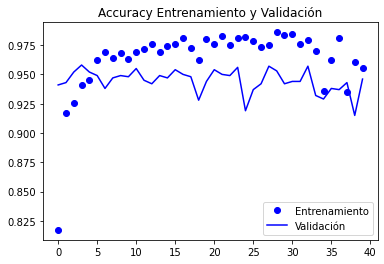

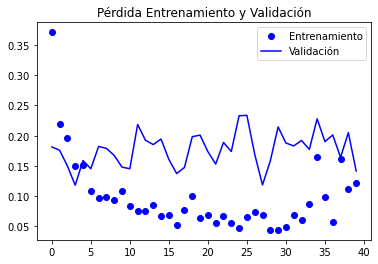

In [78]:
show_graphs(train_model4)

y evaluamos sobre el conjunto de test

In [79]:
model4.evaluate(test_generator)

114/114 [==============================] - 4s 36ms/step - loss: 0.1381 - acc: 0.9524


[0.13812918961048126, 0.9523599743843079]

#### Posible mejora para el modelo 4

Para hacer uso del Data Augmentation, utilizamos el generador `train_generator_aug`, que pa fue creado con la configuración necesaria para realizar transformaciones a las imágenes (en el apartado de preprocesamiento tiene más información de esto). Fíjese que el generador para los datos de validación no varía, porque debemos ir validando el modelo con una referencia original.

In [80]:
train_model4_improvement = model4_improvement.fit(
      train_generator_aug,
      steps_per_epoch=200,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/40
200/200 [==============================] - 18s 80ms/step - loss: 0.6035 - acc: 0.6407 - val_loss: 0.2326 - val_acc: 0.9300
Epoch 2/40
200/200 [==============================] - 16s 81ms/step - loss: 0.4214 - acc: 0.8081 - val_loss: 0.2764 - val_acc: 0.9000
Epoch 3/40
200/200 [==============================] - 16s 81ms/step - loss: 0.4070 - acc: 0.8127 - val_loss: 0.2195 - val_acc: 0.9260
Epoch 4/40
200/200 [==============================] - 16s 80ms/step - loss: 0.3481 - acc: 0.8574 - val_loss: 0.2127 - val_acc: 0.9340
Epoch 5/40
200/200 [==============================] - 16s 81ms/step - loss: 0.3258 - acc: 0.8715 - val_loss: 0.2581 - val_acc: 0.9110
Epoch 6/40
200/200 [==============================] - 16s 78ms/step - loss: 0.3248 - acc: 0.8686 - val_loss: 0.2208 - val_acc: 0.9240
Epoch 7/40
200/200 [==============================] - 16s 81ms/step - loss: 0.3631 - acc: 0.8479 - val_loss: 0.2149 - val_acc: 0.9190
Epoch 8/40
200/200 [==============================] - 16s 79ms

Mostramos las gráficas de precisión y validación

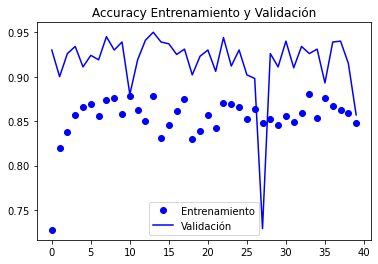

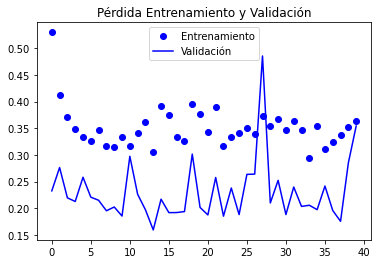

In [81]:
show_graphs(train_model4_improvement)

y evaluamos sobre test

In [82]:
model4_improvement.evaluate(test_generator)

114/114 [==============================] - 4s 36ms/step - loss: 0.3971 - acc: 0.8390


[0.3970770239830017, 0.8389942646026611]

## 5. Análisis de resultados

Para analizar los resultados, vamos a seguir la siguiente estructura por cada modelo:
- métricas de evaluación
- comportamiento con gráficas
- modelo de mejora propuesto
- resultados de la mejora
- comparación con otros modelos

### 5.1 Modelo 1 

El primer modelo, a pesar de ser bastante simple, ha obtenido unos resultados asombrosos con un 98% para el entrenamiento y un 92% para validación. Se ha visto reflejado de la misma forma en sus valores de la función de pérdida, casi 0 en el primer caso.

En cuanto al proceso de entrenamiento, podemos observar como a partir del 3er epoch la gráfica de validación empieza a no tender al máximo en el valor de precisión y a no tender al mínimo en el valor de pérdida. Podríamos decir, por tanto, que el modelo empieza a sobreajustarse a partir del 3er epoch.

No obstante, el valor sobre el conjunto de test (ajeno a todo lo visto anteriormente) ha sido bastante bueno, con un rendimiento del 92%.

La mejora propuesta en este caso ha sido el uso de early-stopping para frenar el entrenamiento cuando este empezara a dar indicios de sobreajuste. El entrenamiento no ha parado, debido a que el valor de patience no se ha superado, pero igualmente se aprecia en las gráficas que la precisión y pérdida en el conjunto de validación empiezan a flaquear a partir del epoch 4.

Podemos decir acerca del primer modelo, que si bien empieza a sobreajustarse en poco tiempo, obtiene unos resultados muy buenos desde el principio y con tan solo 10 epochs sabe generalizar bastante bien el problema.

### 5.2 Modelo 2

El segundo modelo ha actuado bastante bien desde el principio, con unos rendimientos de ~93% tanto para entrenamiento como para validación, por lo que podríamos decir que no se ha sobreajustado. En el proceso de entrenamiento se nos confirma esta hipótesis, mostrándonos como tanto en el valor de la precisión como en la pérdida (que van correlacionados), las gráficas de ambos conjuntos van en la misma dirección.

El valor sobre el conjunto de test ha sido bueno con un 92-93%.

Hablando ahora de la posible mejora, podemos observar la existencia de sobreajuste, por el comportamiento de las gráficas, a partir del epoch 7. Sin embargo, los valores de rendimiento sobre entrenamiento y validación son mejores, con un casi 100% sobre entrenamiento (denota sobreajuste) y un 95% sobre validación.

La última palabra aquí la tendría el rendimiento sobre el test, que resulta ser algo mejor, con un 95%. 

Podemos decir acerca del segundo modelo, que su primera versión tiene una fase de entrenamiento natural y balanceada, con ambos conjuntos (entrenamiento y validación) caminando en una misma dirección. Su segunda versión denota errores en determinados epochs, pero en ciertos momentos alcanza picos de mejor valor.

### 5.3 Modelo 3

El tercer modelo obtiene los mejores resultados hasta ahora en todos los conjuntos: aporx. 95%/95%/95% para entrenamiento, validación y test; y se puede confirmar viendo como se acercan las gráficas de entrenamiento y validación en las dos representaciones.

Hablando de la mejora realizada con el uso de Dropout, si nos fijamos en la primera gráfica (precisión), podemos ver algo inusual en otras gráficas vistas: el valor de precisión en la validación tendía a ser mejor que en el entrenamiento. Podríamos decir que esta situación denota algo de infrajuste en los datos, ya que lo más normal sería que el rendimiento fuera algo mejor en el entrenamiento.

Sin embargo, aunque los resultados en comparación al primer 3er modelo no son mejores, no se quedan atrás con casi un 95% de rendimiento sobre test.

Podemos decir que este modelo se encuentra en la línea de los anteriores con la diferencia de que en la primera versión hemos obtenido lo que hasta ahora son los mejores rendimientos en el problema que estamos abordando.

### 5.4 Modelo 4

El cuarto modelo presenta sobreajuste en su primera versión, con un rendimiento de ~95% en entrenamiento y ~94% en test, algo que se puede ver en las gráficas, donde el valor de precisión y pérdida presenta cambios muy bruscos durante el entrenamiento. 

La segunda versión de este modelo, usando Data Augmentation, no solo no ha mejorado el modelo sino que ha producido infrajuste, con un rendimiento de ~84% en entrenamiento y un ~85% en test. Probablemente el motivo sea que, en el epoch 40, había un pico hacia abajo.

En conclusión, no podemos decir que este modelo haya mejorado a los anteriores (desde luego no mejora el 3er modelo), pero sus resultados son aceptables.

### Conclusiones finales

Como conclusión final, debemos decir que aunque haya modelos mejores o peores, lo cierto es que todos los rendimientos ha rondado el 90% o superior. Podemos ver de esta manera como las redes convolucionales aportan un muy buen resultado al problema que estamos estudiando, pudiendo utilziar cualquiera de los 4 modelos, obteniendo resultados decentes.

El mejor modelo ha sido el modelo número 3, que es el que ha aportado mejores rendimientos por igual en los diferentes conjuntos. Por tanto, este va a ser el modelo que probemos con nuestra webcam.

### Prueba webcam

Copiamos y pegamos el código proporcionado para realizar capturas de forma local. La primera celda, habilitará la webcam de nuestro PC y realizará una captura con ella.

In [ ]:
from IPython.display import HTML, display, update_display

main_text = """
<video id="video" width="320" height="240" autoplay style="display:none"></video>
<canvas id="canvas" width="320" height="240"  ></canvas>

<script>
// Grab elements, create settings, etc.
var video = document.getElementById('video');

// Get access to the camera!
if(navigator.mediaDevices && navigator.mediaDevices.getUserMedia) {
    // Not adding `{ audio: true }` since we only want video now
    navigator.mediaDevices.getUserMedia({ video: true }).then(function(stream) {
        //video.src = window.URL.createObjectURL(stream);
        //video.play();
        video.srcObject=stream;
        video.play();
    });
}

// Elements for taking the snapshot
var canvas = document.getElementById('canvas');
var context = canvas.getContext('2d');
var video = document.getElementById('video');


// Trigger photo take

setInterval(function() {
    context.drawImage(video, 0, 0, 320, 240);
    var myCanvas = document.getElementById('canvas');
    var image = myCanvas.toDataURL("image/png");
    IPython.notebook.kernel.execute("image = '" + image + "'")
    
}, 2);

</script>

"""
HTML(main_text)

Lo siguiente será tomar la imagen, convertirla a formato RGB y redimensionarla al tamaño adecuado para los modelos (128x128)

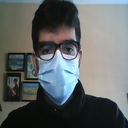

In [27]:
from PIL import Image
import base64
from numpy import asarray
import io
import numpy as np
import time

pil_im = Image.open(io.BytesIO(base64.b64decode(image.split(',')[1]))) # versión en local
pil_im = pil_im.convert('RGB')
pil_im = pil_im.resize(IMAGE_SIZE, Image.ANTIALIAS)
pil_im

Por último, escalamos los valores del tensor y se lo pasamos al modelo para que nos indique si la persona lleva o no mascarilla. En este caso, hemos establecido el valor umbral en 0.5:

- Si y < 0.5 -> si lleva mascarilla
- Si y >= 0.5 -> no lleva mascarilla

Debemos recordar que, al ser este un problema de clasificación binaria, la capa de salida de nuestro modelo posee un único nodo con función de activación sigmoide. El valor que devuelve dicho nodo se puede interpretar como la "probabilidad" de pertenecer a la clase 1 (en este caso, NO llevar mascarilla).

In [28]:
im = np.asarray(pil_im) / 255
print(model3.predict(np.array([im])).argmax())  # Muestra la salida del modelo y el resultado (con o sin mascarilla)
result = 'con mascarilla' if model3.predict(np.array([im]))[0] < 0.5 else 'sin mascarilla'
print(result)

0
con mascarilla


Como podemos ver, el modelo ha dicho que en la imagen llevamos mascarilla, ¡lo cual es cierto! Pero, ¿cúan seguro está de eso? En el siguiente código podemos ver la salida de la función sigmoide o probabilidad. 

In [29]:
model3.predict(np.array([im]))

array([[0.00019134]], dtype=float32)

Si anteriormente decíamos que <0.5 es llevar mascarilla, desde luego el modelo nos dice que sabe con bastante seguridad que la persona lleva mascarilla. Por tanto, el resultado es muy bueno.

Ahora volvemos a copiar el código anterior con el objetivo de tomar otra imagen, esta vez de nosotros mismos sin mascarilla.

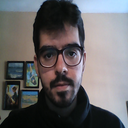

In [31]:
from PIL import Image
import base64
from numpy import asarray
import io
import numpy as np
import time

pil_im = Image.open(io.BytesIO(base64.b64decode(image.split(',')[1]))) # versión en local
pil_im = pil_im.convert('RGB')
pil_im = pil_im.resize(IMAGE_SIZE, Image.ANTIALIAS)
pil_im

In [32]:
im = np.asarray(pil_im) / 255
print(model3.predict(np.array([im])).argmax())  # Muestra la salida del modelo y el resultado (con o sin mascarilla)
result = 'con mascarilla' if model3.predict(np.array([im]))[0] < 0.5 else 'sin mascarilla'
print(result)

0
sin mascarilla


Vemos que el modelo ha predicho correctamente que no llevamos mascarilla, ¡fantástico! ¿Estará tan seguro esta vez?

In [33]:
model3.predict(np.array([im]))

array([[0.9458987]], dtype=float32)

Pues parece que sí porque nos comenta que la imagen pertenece a la clase 1 (without mask) con un 94% de certeza.

## 6. Bibliografía

- Todo lo visto hasta ahora en la asignatura Deep Learning del MII (Universidad de Sevilla) para identificar y aprender a usar distintas configuraciones de modelos, optimizadores, técnicas de regularización, etc.
- API de Keras para la construcción, entrenamiento y evaluación de modelos. Enlace a la API: https://keras.io/api/
- Documentación de Numpy para trabajar con los tensores. Enlace a la API: https://numpy.org/doc/stable/reference/index.html
- Documentación de tensorflow para la importación de algunos optimizadores o funciones de activación que no estaban disponibles en keras. Enlace a la API: https://www.tensorflow.org/api_docs
